In [14]:
import sys
import sys
import os
# makes it so that tensorflow doesn't print warnings on startup
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all logs, 1 = filter INFO, 2 = filter WARNING, 3 = only errors
import tensorflow as tf

In [4]:
# If having trouble with pyenv and python versions, ensure that this print statement says 3.11.9
print("Python version: " + sys.version)
print("Tensorflow version: " + tf.__version__)

Python version: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Tensorflow version: 2.19.0


In [5]:
# Paths to your data folders
base_dirs = ['Hey-Waldo/64', 'Hey-Waldo/64-bw', 'Hey-Waldo/64-gray',
             'Hey-Waldo/128', 'Hey-Waldo/128-bw', 'Hey-Waldo/128-gray',
             'Hey-Waldo/256', 'Hey-Waldo/256-bw', 'Hey-Waldo/256-gray']

image_datasets = []

#TODO: only make dataset using colored images
color_dirs = ['Hey-Waldo/64', 'Hey-Waldo/128', 'Hey-Waldo/256']

# create individual datasets of each directory from COLOR Hey-Waldo dataset
for path in color_dirs:
    if os.path.exists(path):
        ds = tf.keras.preprocessing.image_dataset_from_directory(
            path,
            labels='inferred',
            label_mode='binary',
            image_size=(128, 128),  # Resize all to common shape
            batch_size=32,
            # causes issues with channel numbers if all aren't set to RGB
            color_mode='rgb' # if 'gray' not in path and 'bw' not in path else 'grayscale'
        )
        image_datasets.append(ds)

# Combine all into one dataset
full_dataset = image_datasets[0]
for ds in image_datasets[1:]:
    full_dataset = full_dataset.concatenate(ds)

# Shuffle and split
full_dataset = full_dataset.shuffle(1000)
train_size = int(0.8 * len(full_dataset))
train_ds = full_dataset.take(train_size)
val_ds = full_dataset.skip(train_size)

for images, labels in train_ds.take(1):
    print(images.shape)  # Should be (batch_size, 128, 128, 3)
    print(labels.shape)

Found 5376 files belonging to 2 classes.
Found 1344 files belonging to 2 classes.
Found 317 files belonging to 2 classes.
(32, 128, 128, 3)
(32, 1)


In [6]:
from tensorflow.keras import layers, models, Input

model = models.Sequential([
    Input(shape=(128, 128, 3)),              # ✅ define input layer explicitly
    layers.Rescaling(1./255),                # ✅ normalize pixel values
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')    # Binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds, validation_data=val_ds, epochs=10)


Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 23s 112ms/step - accuracy: 0.9547 - loss: 0.1259 - val_accuracy: 0.9830 - val_loss: 0.1244
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 22s 120ms/step - accuracy: 0.9841 - loss: 0.0972 - val_accuracy: 0.9886 - val_loss: 0.0622
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 26s 141ms/step - accuracy: 0.9846 - loss: 0.0920 - val_accuracy: 0.9779 - val_loss: 0.1184
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 73s 408ms/step - accuracy: 0.9842 - loss: 0.0879 - val_accuracy: 0.9830 - val_loss: 0.0904
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.9870 - loss: 0.0697 - val_accuracy: 0.9872 - val_loss: 0.0799
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - accuracy: 0.9821 - loss: 0.0947 - val_accuracy: 0.9858 - val_loss: 0.0756
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 29s 155ms/step - accuracy: 0.9848 - loss: 0.0819 - val_accuracy: 0.9808 - val_loss: 0.0961
Epoch 8/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 33s 175ms/step - accuracy: 0.9854 - loss: 0

In [7]:
model.save("waldo_classifier.h5")

In [15]:
import tensorflow as tf
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt

def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


In [16]:
def sliding_window(image, step=32, window_size=(128, 128)):
    for y in range(0, image.shape[0] - window_size[1], step):
        for x in range(0, image.shape[1] - window_size[0], step):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

In [17]:
def detect_waldo_in_image(model, full_image, window_size=(128, 128), step=32, threshold=0.9):
    boxes = []

    for (x, y, window) in sliding_window(full_image, step=step, window_size=window_size):
        if window.shape[0] != window_size[1] or window.shape[1] != window_size[0]:
            continue  # Skip incomplete patches at the edge

        input_img = tf.image.resize(window, window_size)
        input_img = tf.expand_dims(input_img / 255.0, axis=0)  # Normalize

        prediction = model.predict(input_img, verbose=0)[0][0]

        if prediction >= threshold:
            boxes.append((x, y, prediction))

    return boxes


In [18]:
def draw_detections(image, boxes, window_size=(128, 128)):
    img_copy = image.copy()
    for (x, y, score) in boxes:
        cv2.rectangle(img_copy, (x, y), (x + window_size[0], y + window_size[1]), (255, 0, 0), 2)
        cv2.putText(img_copy, f"{score:.2f}", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 0, 0), 1)
    return img_copy


In [24]:
from tensorflow.keras.models import load_model

model = load_model("waldo_classifier.h5")

img_path = "Hey-Waldo/original-images/1.jpg"
# img_path = "Hey-Waldo/256/waldo/1_1_1.jpg"
image = load_image(img_path)

In [25]:
x, y = 0, 0
test_window = image[y:y+128, x:x+128]  # Pick a spot you know Waldo is in
test_window = cv2.resize(test_window, (128, 128))
test_window = test_window.astype("float32") / 255.0
test_window = np.expand_dims(test_window, axis=0)

prediction = model.predict(test_window)
print("Prediction score:", prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Prediction score: [[0.01233897]]


Threshold: 12338


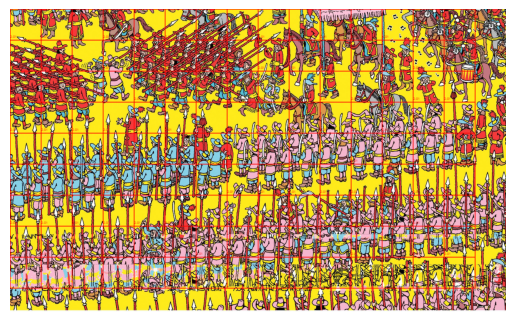

In [ ]:
# Example threshold values
threshold = 0.01233897

# Multiply by 100000 to shift the decimal point
threshold_display = int(threshold * 1000000)

# Display as 15 instead of 0.00015
print(f"Threshold: {threshold_display}")

boxes = detect_waldo_in_image(model, image, window_size=(128, 128), step=128, threshold=threshold)
# for some reason every single bounding box has the same threshold value???

result_image = draw_detections(image, boxes)

# plt.figure(figsize=(12, 12))
# plt.title(f"Threshold: {threshold_display}")
plt.imshow(result_image)
plt.axis('off')
plt.show()